# Installs and imports

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.5 MB/s eta 0:00:00


In [3]:
#import libraries
import os #to import library os
import cv2 #to import library cv2
import numpy as np #to import numpy as np
import matplotlib.pyplot as plt #to import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
# import tensorflow_addons as tfa #to import tensorflow_adds as tfa
from tensorflow.keras import datasets, layers, models
import inspect

In [4]:
from sklearn.model_selection import train_test_split

In [52]:
import keras
import matplotlib.pyplot as plt
import statistics

Pseudo-random state

In [5]:
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Download and pre-process images

In [6]:
#to access the data file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# image_path = "/content/drive/MyDrive/IMG_SEL"
image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas" # path of the image
image_list = os.listdir(image_path) #to obtain a list of the image's name

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os


image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas"
image_list = os.listdir(image_path)

images = []
labels = []


for image_name in image_list:
    path = os.path.join(image_path, image_name)
    image = Image.open(path,)
    image = image.resize((1024, 884))

    if image.mode != 'L':
        image = image.convert('L')


    image_array = np.array(image)
    images.append(image_array)


    if image_name.startswith("PVA_MCC_0"):
        labels.append(33.18)
    elif image_name.startswith("PVA_MCC_1"):
        labels.append(18.87)
    elif image_name.startswith("PVA_MCC_3"):
        labels.append(18.74)
    elif image_name.startswith("PVA_MCC_5"):
        labels.append(14.23)


images = np.array(images)
labels = np.array(labels)


images = images.reshape(-1, 1024, 884, 1)


datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    zoom_range=0.1,
    vertical_flip=True,
    fill_mode="wrap"
)


datagen.fit(images)


augmented_images = []
augmented_labels = []


for i in range(40):
    it = datagen.flow(images, labels, shuffle=False)
    batch_images, batch_labels = next(it)

    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


final_images = np.concatenate((images, augmented_images))
final_labels = np.concatenate((labels, augmented_labels))

print("Final dataset size:", len(final_images))


Final dataset size: 1327


In [18]:
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.3, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [47]:
train_images = tf.convert_to_tensor(train_images/255, dtype=tf.float32)
train_images = tf.image.resize(train_images, [250, 250])
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor((test_images/255), dtype=tf.float32)
test_images = tf.image.resize(test_images, [250, 250])
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)
val_images = tf.convert_to_tensor((val_images/255), dtype=tf.float32)
val_images = tf.image.resize(val_images, [250, 250])
vak_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

# Train CNN model

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 241.1262 - mae: 14.1392 - mse: 241.1262 - val_loss: 106.6138 - val_mae: 8.5783 - val_mse: 106.6138
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 22.7460 - mae: 3.5439 - mse: 22.7460 - val_loss: 52.6132 - val_mae: 4.8182 - val_mse: 52.6132
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.8356 - mae: 2.8777 - mse: 15.8356 - val_loss: 38.1289 - val_mae: 4.0283 - val_mse: 38.1289
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.0279 - mae: 2.5640 - mse: 12.0279 - val_loss: 50.2589 - val_mae: 4.8609 - val_mse: 50.2589
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.0459 - mae: 2.5254 - mse: 12.0459 - val_loss: 41.5076 - val_mae: 4.3899 - val_mse: 41.5076
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9007 - mae: 2.2728 - mse: 8.9007 - val_loss: 61.2299 - val_mae: 5.2791 - val_mse: 61.2299
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0384 - mae: 2.3001 - ms

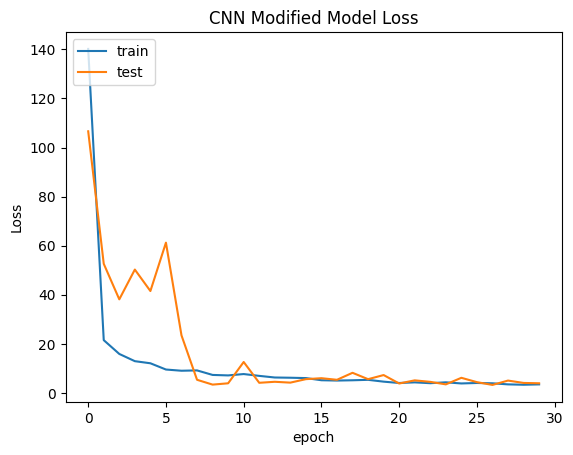

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
111
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 233.9168 - mae: 13.8266 - mse: 233.9168 - val_loss: 100.6553 - val_mae: 8.2887 - val_mse: 100.6553
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.4079 - mae: 3.4610 - mse: 21.4079 - val_loss: 64.9323 - val_mae: 5.7241 - val_mse: 64.9323
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.5750 - mae: 2.8723 - mse: 16.5750 - val_loss: 37.9684 - val_mae: 3.9845 - val_mse: 37.9684
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.3888 - mae: 2.4860 - mse: 11.3888 - val_loss: 28.9805 - val_mae: 3.6666 - val_mse: 28.9805
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.9848 - mae: 2.4414 - mse: 10.9848 - val_loss: 32.2641 - val_mae: 3.7057 - val_mse: 32.2641
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0684 - mae: 2.1324 - mse: 8.0684 - val_loss: 23.4086 - val_mae: 3.4021 - val_mse: 23.4086
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

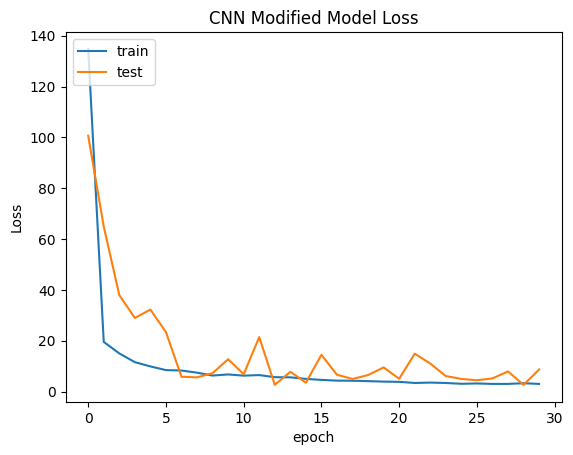

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
100
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 229.5733 - mae: 13.7241 - mse: 229.5733 - val_loss: 109.0858 - val_mae: 8.7812 - val_mse: 109.0858
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.0461 - mae: 3.2568 - mse: 20.0461 - val_loss: 56.1983 - val_mae: 5.0982 - val_mse: 56.1983
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.8762 - mae: 2.6777 - mse: 12.8762 - val_loss: 34.8887 - val_mae: 3.7327 - val_mse: 34.8887
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6838 - mae: 2.5400 - mse: 11.6838 - val_loss: 44.3651 - val_mae: 4.3629 - val_mse: 44.3651
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.8396 - mae: 2.4086 - mse: 10.8396 - val_loss: 25.4098 - val_mae: 3.2025 - val_mse: 25.4098
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8814 - mae: 2.3695 - mse: 9.8814 - val_loss: 19.7651 - val_mae: 2.7420 - val_mse: 19.7651
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

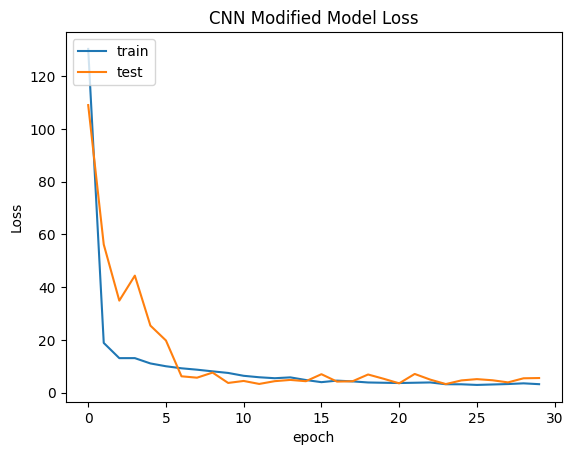

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
66
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 245.7376 - mae: 14.4170 - mse: 245.7376 - val_loss: 110.0196 - val_mae: 8.7563 - val_mse: 110.0196
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.5064 - mae: 2.8416 - mse: 14.5064 - val_loss: 58.8421 - val_mae: 5.2362 - val_mse: 58.8421
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7624 - mae: 2.3765 - mse: 9.7624 - val_loss: 28.4805 - val_mae: 3.4160 - val_mse: 28.4805
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1508 - mae: 2.3158 - mse: 9.1508 - val_loss: 28.5602 - val_mae: 3.3695 - val_mse: 28.5602
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.7148 - mae: 2.4977 - mse: 11.7148 - val_loss: 36.6304 - val_mae: 5.0935 - val_mse: 36.6304
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5915 - mae: 2.2764 - mse: 8.5915 - val_loss: 38.8087 - val_mae: 4.8596 - val_mse: 38.8087
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8

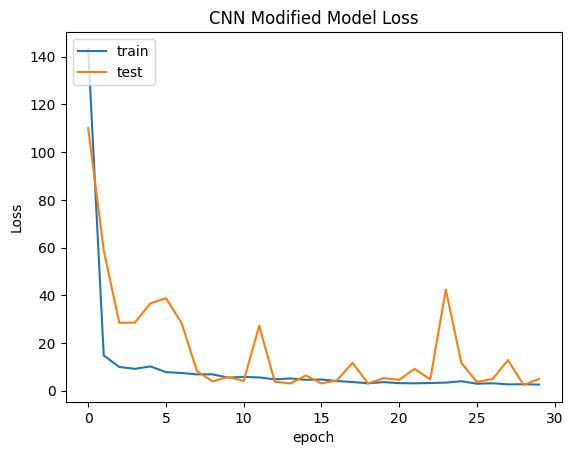

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
101
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 228.8674 - mae: 13.6783 - mse: 228.8674 - val_loss: 84.9570 - val_mae: 7.1688 - val_mse: 84.9570
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.5323 - mae: 3.3121 - mse: 19.5323 - val_loss: 47.5596 - val_mae: 4.5568 - val_mse: 47.5596
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.9086 - mae: 2.3942 - mse: 9.9086 - val_loss: 40.4072 - val_mae: 4.0882 - val_mse: 40.4072
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.8815 - mae: 2.5115 - mse: 10.8815 - val_loss: 29.6983 - val_mae: 3.4002 - val_mse: 29.6983
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8429 - mae: 2.3573 - mse: 9.8429 - val_loss: 28.8077 - val_mae: 3.6722 - val_mse: 28.8077
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6487 - mae: 2.5237 - mse: 11.6487 - val_loss: 16.3055 - val_mae: 2.9945 - val_mse: 16.3055
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 

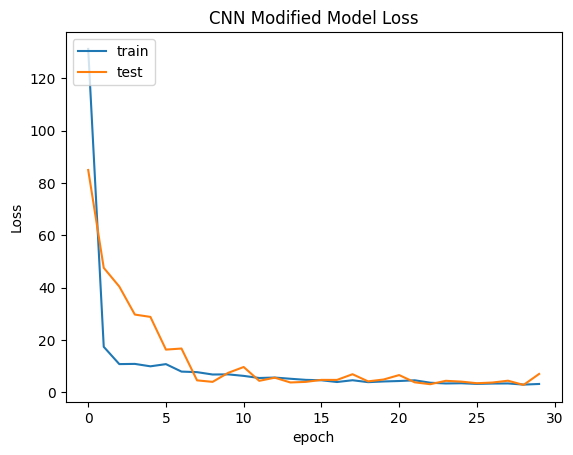

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
103
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 212.5542 - mae: 13.1457 - mse: 212.5542 - val_loss: 74.8035 - val_mae: 6.4135 - val_mse: 74.8035
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.4811 - mae: 3.3445 - mse: 20.4811 - val_loss: 43.1895 - val_mae: 4.2610 - val_mse: 43.1895
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.9116 - mae: 2.9302 - mse: 15.9116 - val_loss: 44.0759 - val_mae: 4.3078 - val_mse: 44.0759
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2252 - mae: 2.5190 - mse: 12.2252 - val_loss: 36.9130 - val_mae: 3.6240 - val_mse: 36.9130
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3652 - mae: 2.3499 - mse: 10.3652 - val_loss: 42.0983 - val_mae: 3.7904 - val_mse: 42.0983
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0607 - mae: 2.3261 - mse: 10.0607 - val_loss: 33.4377 - val_mae: 4.0227 - val_mse: 33.4377
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

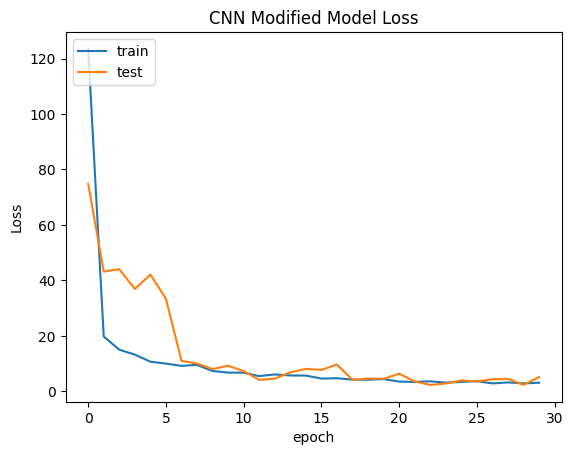

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
34
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 226.2345 - mae: 13.6318 - mse: 226.2345 - val_loss: 123.0233 - val_mae: 9.5258 - val_mse: 123.0233
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 20.9313 - mae: 3.4450 - mse: 20.9313 - val_loss: 79.2341 - val_mae: 6.8377 - val_mse: 79.2341
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.0463 - mae: 2.7842 - mse: 14.0463 - val_loss: 60.7742 - val_mae: 5.4048 - val_mse: 60.7742
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.4219 - mae: 2.5855 - mse: 12.4219 - val_loss: 42.4571 - val_mae: 4.3191 - val_mse: 42.4571
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1733 - mae: 2.2595 - mse: 9.1733 - val_loss: 45.8600 - val_mae: 4.4794 - val_mse: 45.8600
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2366 - mae: 2.1442 - mse: 8.2366 - val_loss: 27.1278 - val_mae: 3.0253 - val_mse: 27.1278
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

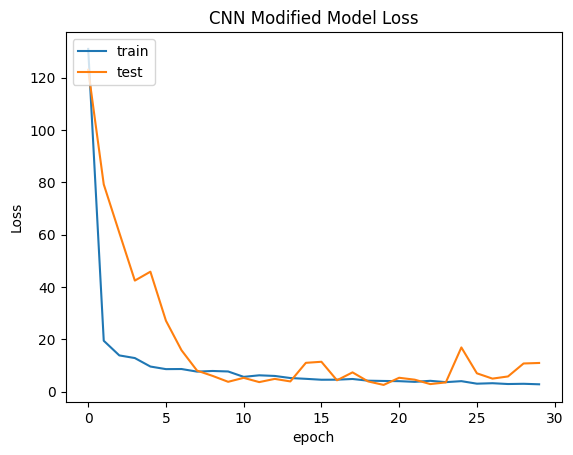

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
92
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 236.1508 - mae: 13.9122 - mse: 236.1508 - val_loss: 146.2329 - val_mae: 10.6506 - val_mse: 146.2329
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.3568 - mae: 3.2318 - mse: 18.3568 - val_loss: 59.0110 - val_mae: 5.3104 - val_mse: 59.0110
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7779 - mae: 2.7293 - mse: 13.7779 - val_loss: 37.6729 - val_mae: 3.8621 - val_mse: 37.6729
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9150 - mae: 2.5303 - mse: 11.9150 - val_loss: 41.8302 - val_mae: 4.2295 - val_mse: 41.8302
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3793 - mae: 2.3177 - mse: 9.3793 - val_loss: 36.8368 - val_mae: 4.0234 - val_mse: 36.8368
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0715 - mae: 2.1937 - mse: 8.0715 - val_loss: 19.9239 - val_mae: 3.1173 - val_mse: 19.9239
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

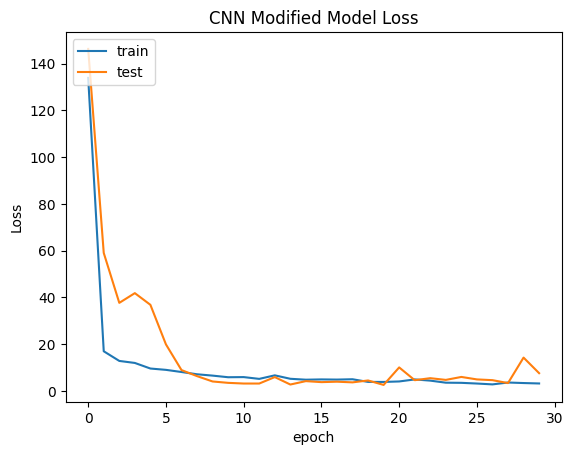

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
68
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 215.9041 - mae: 13.1577 - mse: 215.9041 - val_loss: 103.7075 - val_mae: 8.4413 - val_mse: 103.7075
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.9800 - mae: 3.3605 - mse: 20.9800 - val_loss: 50.3824 - val_mae: 4.7091 - val_mse: 50.3824
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.9057 - mae: 2.9320 - mse: 16.9057 - val_loss: 43.8221 - val_mae: 4.2135 - val_mse: 43.8221
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.4943 - mae: 2.7544 - mse: 13.4943 - val_loss: 38.3966 - val_mae: 3.6899 - val_mse: 38.3966
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.0039 - mae: 2.3549 - mse: 10.0039 - val_loss: 34.6256 - val_mae: 3.6899 - val_mse: 34.6256
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8360 - mae: 2.2277 - mse: 8.8360 - val_loss: 25.7344 - val_mae: 3.4830 - val_mse: 25.7344
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

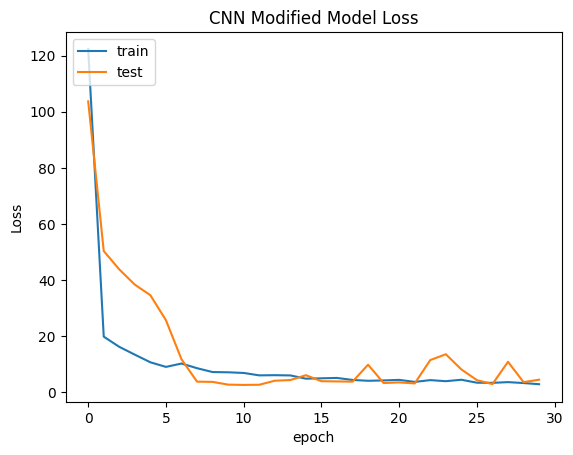

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
106
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 234.2106 - mae: 13.9388 - mse: 234.2106 - val_loss: 101.0960 - val_mae: 8.2328 - val_mse: 101.0960
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.6328 - mae: 3.1010 - mse: 17.6328 - val_loss: 52.4807 - val_mae: 4.7872 - val_mse: 52.4807
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.3061 - mae: 2.7219 - mse: 13.3061 - val_loss: 47.1866 - val_mae: 4.5610 - val_mse: 47.1866
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.0637 - mae: 2.5529 - mse: 12.0637 - val_loss: 36.1588 - val_mae: 4.0485 - val_mse: 36.1588
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6135 - mae: 2.3148 - mse: 9.6135 - val_loss: 25.3815 - val_mae: 3.5309 - val_mse: 25.3815
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5733 - mae: 2.2797 - mse: 9.5733 - val_loss: 17.0753 - val_mae: 2.7503 - val_mse: 17.0753
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

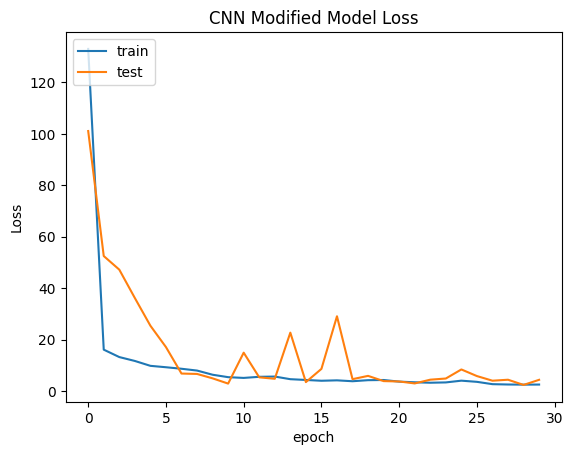

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
98
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 228.6862 - mae: 13.6438 - mse: 228.6862 - val_loss: 88.2032 - val_mae: 7.4261 - val_mse: 88.2032
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.8342 - mae: 3.4063 - mse: 21.8342 - val_loss: 61.9172 - val_mae: 5.4543 - val_mse: 61.9172
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.6694 - mae: 2.8410 - mse: 15.6694 - val_loss: 37.9272 - val_mae: 3.8974 - val_mse: 37.9272
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.4140 - mae: 2.6081 - mse: 13.4140 - val_loss: 45.0590 - val_mae: 4.3331 - val_mse: 45.0590
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8486 - mae: 2.6122 - mse: 11.8486 - val_loss: 34.3400 - val_mae: 3.4997 - val_mse: 34.3400
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8730 - mae: 2.2911 - mse: 9.8730 - val_loss: 39.0386 - val_mae: 4.3851 - val_mse: 39.0386
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

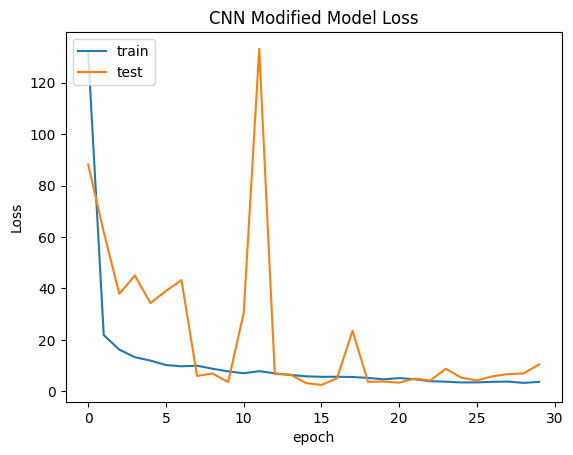

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
92
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 231.9560 - mae: 13.7135 - mse: 231.9560 - val_loss: 67.9444 - val_mae: 5.8890 - val_mse: 67.9444
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24.9383 - mae: 3.7123 - mse: 24.9383 - val_loss: 39.9645 - val_mae: 4.0683 - val_mse: 39.9645
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.3361 - mae: 2.9885 - mse: 17.3361 - val_loss: 48.8364 - val_mae: 4.5577 - val_mse: 48.8364
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.6695 - mae: 2.7487 - mse: 13.6695 - val_loss: 51.0976 - val_mae: 4.8340 - val_mse: 51.0976
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8619 - mae: 2.5521 - mse: 11.8619 - val_loss: 60.0531 - val_mae: 5.5991 - val_mse: 60.0531
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.4553 - mae: 2.3969 - mse: 10.4553 - val_loss: 43.9678 - val_mae: 4.2550 - val_mse: 43.9678
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

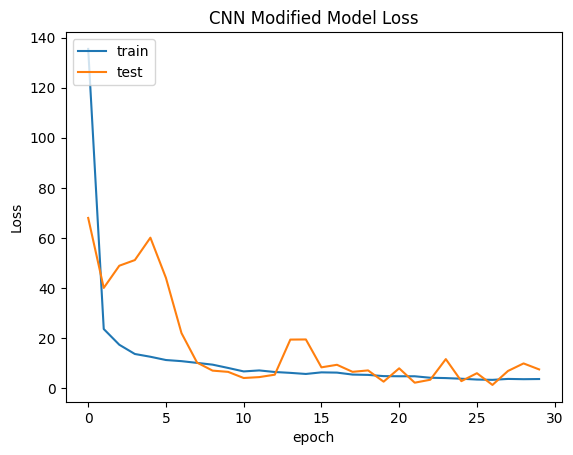

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
52
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 210.6397 - mae: 12.9718 - mse: 210.6397 - val_loss: 127.3279 - val_mae: 9.6861 - val_mse: 127.3279
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.2747 - mae: 3.0680 - mse: 17.2747 - val_loss: 77.9528 - val_mae: 6.6952 - val_mse: 77.9528
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.4191 - mae: 2.6702 - mse: 13.4191 - val_loss: 40.7798 - val_mae: 4.3170 - val_mse: 40.7798
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.1068 - mae: 2.7824 - mse: 15.1068 - val_loss: 28.9448 - val_mae: 3.8084 - val_mse: 28.9448
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.7342 - mae: 2.4371 - mse: 10.7342 - val_loss: 31.3902 - val_mae: 3.9746 - val_mse: 31.3902
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.9702 - mae: 2.4019 - mse: 9.9702 - val_loss: 25.4599 - val_mae: 3.7852 - val_mse: 25.4599
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

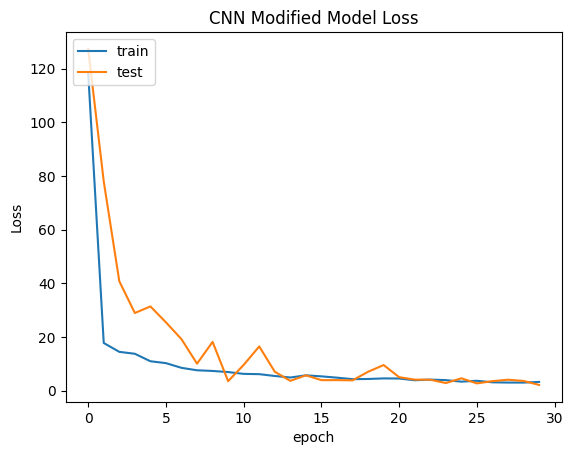

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
121
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 233.7995 - mae: 13.8564 - mse: 233.7995 - val_loss: 65.7168 - val_mae: 5.7733 - val_mse: 65.7168
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.0849 - mae: 3.2717 - mse: 20.0849 - val_loss: 42.7264 - val_mae: 4.2594 - val_mse: 42.7264
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.3372 - mae: 2.8275 - mse: 15.3372 - val_loss: 59.1428 - val_mae: 5.1669 - val_mse: 59.1428
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.9051 - mae: 2.6656 - mse: 12.9051 - val_loss: 41.3439 - val_mae: 4.1763 - val_mse: 41.3439
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8452 - mae: 2.5559 - mse: 11.8452 - val_loss: 66.7184 - val_mae: 5.8397 - val_mse: 66.7184
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3576 - mae: 2.4365 - mse: 10.3576 - val_loss: 59.3257 - val_mae: 5.6165 - val_mse: 59.3257
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

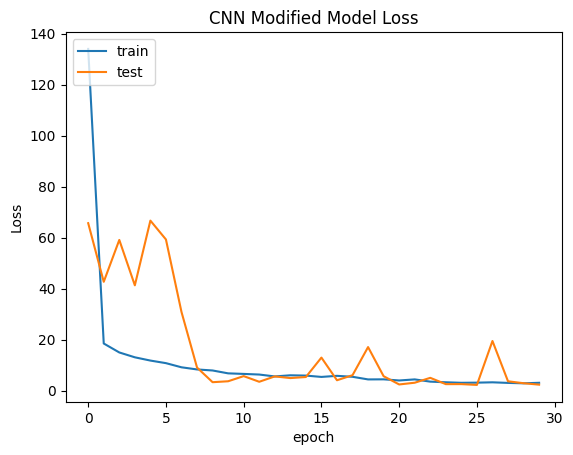

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
107
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 236.5070 - mae: 13.9897 - mse: 236.5070 - val_loss: 102.8563 - val_mae: 8.3247 - val_mse: 102.8563
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.6545 - mae: 3.1582 - mse: 19.6545 - val_loss: 48.5429 - val_mae: 4.5718 - val_mse: 48.5429
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.8233 - mae: 2.7063 - mse: 12.8233 - val_loss: 35.8242 - val_mae: 3.6318 - val_mse: 35.8242
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0975 - mae: 2.6537 - mse: 13.0975 - val_loss: 36.7418 - val_mae: 3.7059 - val_mse: 36.7418
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4533 - mae: 2.2299 - mse: 8.4533 - val_loss: 32.2059 - val_mae: 3.6731 - val_mse: 32.2059
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.9624 - mae: 2.5850 - mse: 12.9624 - val_loss: 14.7659 - val_mae: 2.6532 - val_mse: 14.7659
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

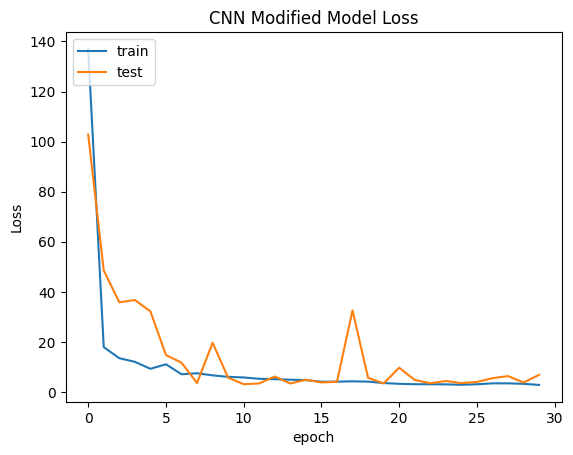

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
199
40
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 244.7388 - mae: 14.2190 - mse: 244.7388 - val_loss: 144.5039 - val_mae: 10.5725 - val_mse: 144.5039
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.6379 - mae: 3.4094 - mse: 22.6379 - val_loss: 50.7020 - val_mae: 4.7087 - val_mse: 50.7020
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0123 - mae: 2.5965 - mse: 13.0123 - val_loss: 36.4480 - val_mae: 3.7591 - val_mse: 36.4480
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.4119 - mae: 2.4272 - mse: 11.4119 - val_loss: 41.9498 - val_mae: 4.1390 - val_mse: 41.9498
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.1754 - mae: 2.5238 - mse: 12.1754 - val_loss: 63.4242 - val_mae: 5.3918 - val_mse: 63.4242
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.1039 - mae: 2.4062 - mse: 10.1039 - val_loss: 22.6097 - val_mae: 3.2324 - val_mse: 22.6097
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━

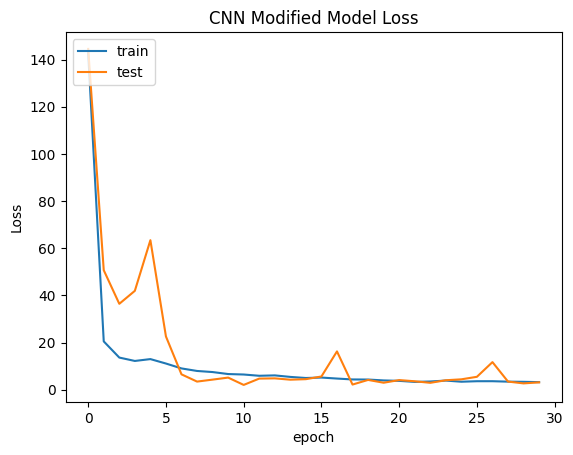

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
199
114
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 228.2369 - mae: 13.6452 - mse: 228.2369 - val_loss: 89.1642 - val_mae: 7.5047 - val_mse: 89.1642
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.9074 - mae: 3.0907 - mse: 18.9074 - val_loss: 50.8945 - val_mae: 4.7362 - val_mse: 50.8945
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.6592 - mae: 2.8419 - mse: 15.6592 - val_loss: 46.1124 - val_mae: 4.4049 - val_mse: 46.1124
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2148 - mae: 2.5244 - mse: 12.2148 - val_loss: 36.0348 - val_mae: 3.8596 - val_mse: 36.0348
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.7226 - mae: 2.4596 - mse: 10.7226 - val_loss: 29.5394 - val_mae: 3.7237 - val_mse: 29.5394
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7044 - mae: 2.1200 - mse: 7.7044 - val_loss: 31.5794 - val_mae: 3.9832 - val_mse: 31.5794
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

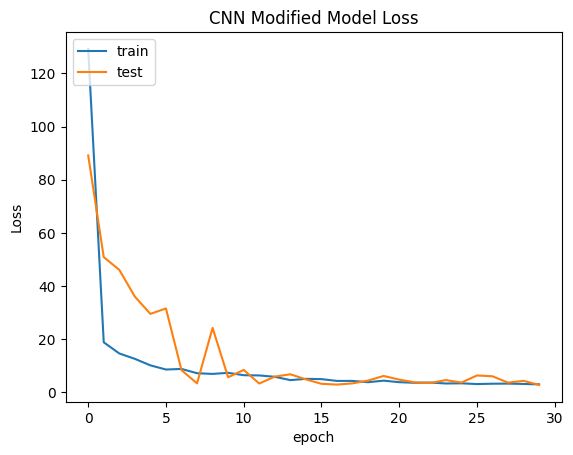

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
111
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 231.3861 - mae: 13.6068 - mse: 231.3861 - val_loss: 135.4424 - val_mae: 10.1641 - val_mse: 135.4424
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.7278 - mae: 3.2989 - mse: 19.7278 - val_loss: 89.7711 - val_mae: 7.5341 - val_mse: 89.7711
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.6141 - mae: 3.0376 - mse: 17.6141 - val_loss: 63.6350 - val_mae: 5.5966 - val_mse: 63.6350
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.1571 - mae: 2.5751 - mse: 12.1571 - val_loss: 38.5755 - val_mae: 4.1105 - val_mse: 38.5755
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7767 - mae: 2.3468 - mse: 9.7767 - val_loss: 31.1758 - val_mae: 4.1954 - val_mse: 31.1758
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2471 - mae: 2.2368 - mse: 9.2471 - val_loss: 18.6395 - val_mae: 2.9346 - val_mse: 18.6395
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

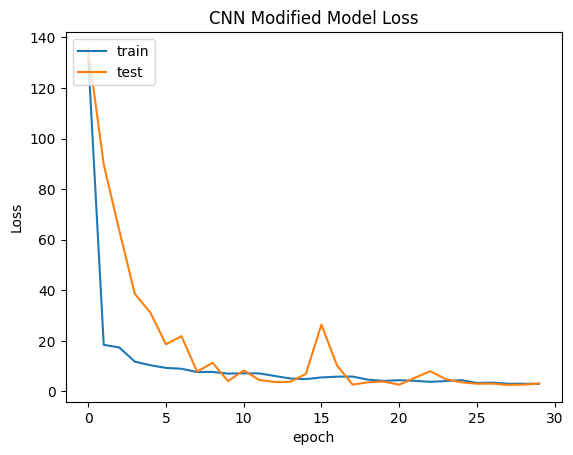

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
110
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 228.2406 - mae: 13.6053 - mse: 228.2406 - val_loss: 103.3824 - val_mae: 8.4317 - val_mse: 103.3824
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.4432 - mae: 3.3898 - mse: 21.4432 - val_loss: 59.9074 - val_mae: 5.1940 - val_mse: 59.9074
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7704 - mae: 2.7599 - mse: 13.7704 - val_loss: 42.6531 - val_mae: 4.3726 - val_mse: 42.6531
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9704 - mae: 2.2643 - mse: 8.9704 - val_loss: 35.9787 - val_mae: 4.1421 - val_mse: 35.9787
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7763 - mae: 2.3462 - mse: 9.7763 - val_loss: 16.0903 - val_mae: 2.9576 - val_mse: 16.0903
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9950 - mae: 2.1778 - mse: 7.9950 - val_loss: 46.5186 - val_mae: 4.7821 - val_mse: 46.5186
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 

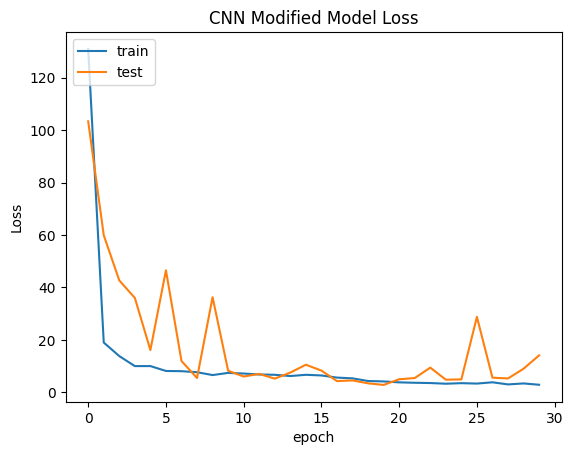

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
93
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 262.5917 - mae: 14.8065 - mse: 262.5917 - val_loss: 97.4511 - val_mae: 7.9915 - val_mse: 97.4511
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.6450 - mae: 3.4913 - mse: 21.6450 - val_loss: 41.9816 - val_mae: 4.1915 - val_mse: 41.9816
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.2309 - mae: 2.8545 - mse: 15.2309 - val_loss: 41.8070 - val_mae: 4.1691 - val_mse: 41.8070
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.1082 - mae: 2.5608 - mse: 12.1082 - val_loss: 46.0007 - val_mae: 4.3972 - val_mse: 46.0007
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5284 - mae: 2.3473 - mse: 9.5284 - val_loss: 39.5439 - val_mae: 4.1908 - val_mse: 39.5439
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4366 - mae: 2.2838 - mse: 9.4366 - val_loss: 12.5191 - val_mae: 2.2990 - val_mse: 12.5191
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8

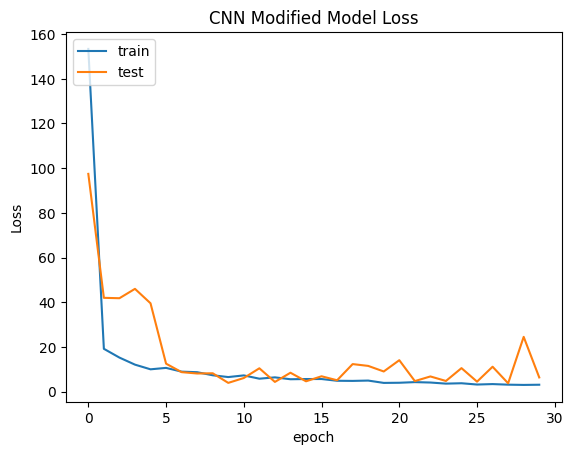

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
123
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 253.2640 - mae: 14.5216 - mse: 253.2640 - val_loss: 101.5483 - val_mae: 8.3113 - val_mse: 101.5483
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23.0950 - mae: 3.5495 - mse: 23.0950 - val_loss: 83.1910 - val_mae: 7.1126 - val_mse: 83.1910
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.7775 - mae: 3.1809 - mse: 19.7775 - val_loss: 64.0962 - val_mae: 5.6531 - val_mse: 64.0962
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.1071 - mae: 2.7877 - mse: 14.1071 - val_loss: 74.1631 - val_mae: 6.6958 - val_mse: 74.1631
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.9408 - mae: 2.6244 - mse: 12.9408 - val_loss: 42.3523 - val_mae: 4.4049 - val_mse: 42.3523
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.9895 - mae: 2.3692 - mse: 9.9895 - val_loss: 49.3978 - val_mae: 5.0413 - val_mse: 49.3978
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

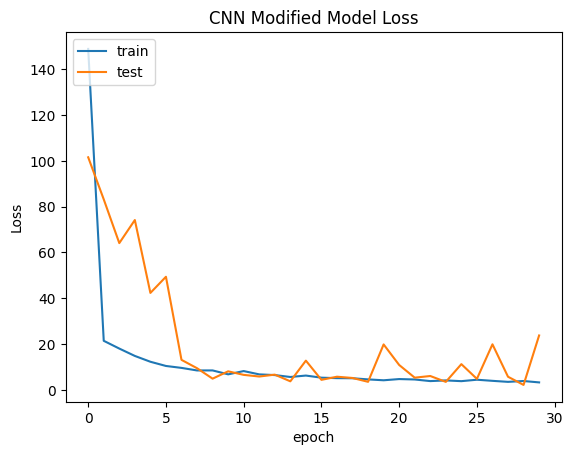

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
84
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 201.7507 - mae: 12.6309 - mse: 201.7507 - val_loss: 94.9342 - val_mae: 7.9189 - val_mse: 94.9342
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.9709 - mae: 3.0036 - mse: 16.9709 - val_loss: 44.8917 - val_mae: 4.4971 - val_mse: 44.8917
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8959 - mae: 2.6023 - mse: 11.8959 - val_loss: 37.3413 - val_mae: 4.0163 - val_mse: 37.3413
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.4945 - mae: 2.4114 - mse: 10.4945 - val_loss: 29.7813 - val_mae: 3.5072 - val_mse: 29.7813
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.1152 - mae: 2.3888 - mse: 10.1152 - val_loss: 114.9822 - val_mae: 7.4353 - val_mse: 114.9822
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8342 - mae: 2.2284 - mse: 8.8342 - val_loss: 62.5723 - val_mae: 5.5617 - val_mse: 62.5723
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

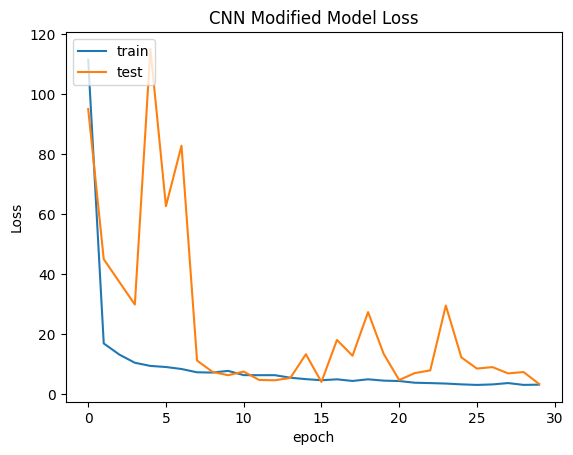

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
101
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 234.0492 - mae: 13.7273 - mse: 234.0492 - val_loss: 86.2139 - val_mae: 7.3208 - val_mse: 86.2139
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.0297 - mae: 3.3620 - mse: 21.0297 - val_loss: 63.9800 - val_mae: 5.6238 - val_mse: 63.9800
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.6779 - mae: 2.7908 - mse: 14.6779 - val_loss: 60.5874 - val_mae: 5.3912 - val_mse: 60.5874
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8409 - mae: 2.5303 - mse: 11.8409 - val_loss: 56.2599 - val_mae: 5.1849 - val_mse: 56.2599
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.6607 - mae: 2.4311 - mse: 10.6607 - val_loss: 63.5149 - val_mae: 5.6885 - val_mse: 63.5149
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3267 - mae: 2.3399 - mse: 10.3267 - val_loss: 28.4326 - val_mae: 4.1468 - val_mse: 28.4326
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

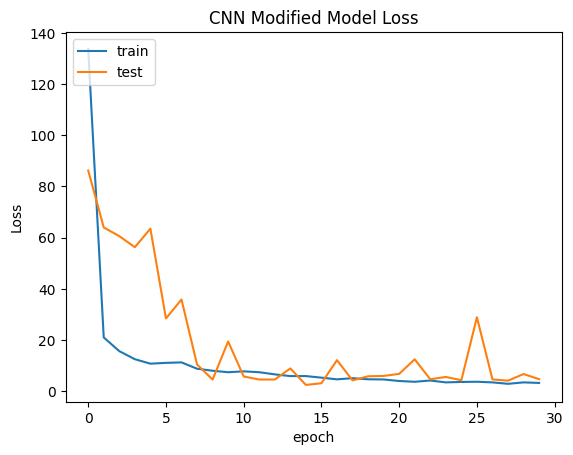

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
64
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 246.3734 - mae: 14.2419 - mse: 246.3734 - val_loss: 105.2314 - val_mae: 8.4823 - val_mse: 105.2314
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.5002 - mae: 3.5710 - mse: 22.5002 - val_loss: 45.2132 - val_mae: 4.3829 - val_mse: 45.2132
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.3439 - mae: 2.8811 - mse: 16.3439 - val_loss: 38.0206 - val_mae: 3.7216 - val_mse: 38.0206
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0778 - mae: 2.4383 - mse: 10.0778 - val_loss: 39.0271 - val_mae: 3.7475 - val_mse: 39.0271
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7711 - mae: 2.2691 - mse: 8.7711 - val_loss: 40.9885 - val_mae: 4.5657 - val_mse: 40.9885
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9486 - mae: 2.2919 - mse: 8.9486 - val_loss: 28.4690 - val_mae: 3.3531 - val_mse: 28.4690
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

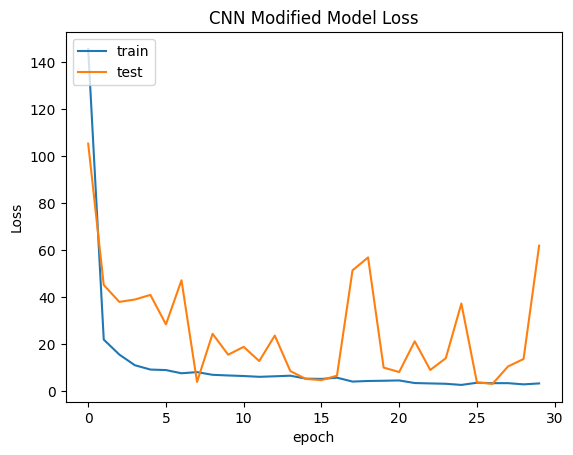

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
199
68
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 260.1665 - mae: 14.7304 - mse: 260.1665 - val_loss: 103.4185 - val_mae: 8.4076 - val_mse: 103.4185
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.4368 - mae: 3.6030 - mse: 22.4368 - val_loss: 85.2230 - val_mae: 7.2342 - val_mse: 85.2230
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.9920 - mae: 3.0086 - mse: 16.9920 - val_loss: 32.1194 - val_mae: 3.9518 - val_mse: 32.1194
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.9645 - mae: 2.9062 - mse: 15.9645 - val_loss: 28.7575 - val_mae: 3.4236 - val_mse: 28.7575
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9730 - mae: 2.5340 - mse: 11.9730 - val_loss: 31.2410 - val_mae: 3.6202 - val_mse: 31.2410
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9002 - mae: 2.3143 - mse: 9.9002 - val_loss: 16.5417 - val_mae: 2.9247 - val_mse: 16.5417
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

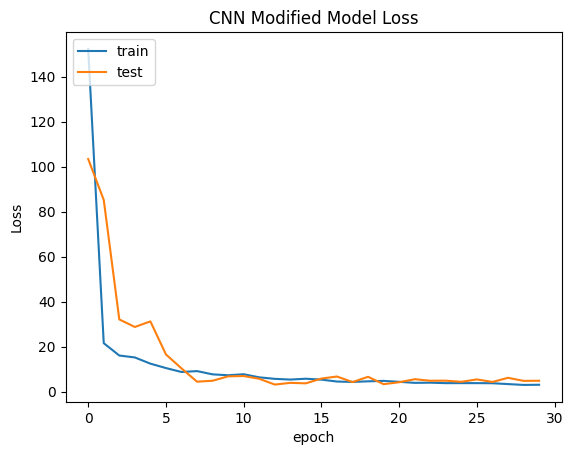

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
117
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 221.8427 - mae: 13.4170 - mse: 221.8427 - val_loss: 90.1759 - val_mae: 7.5856 - val_mse: 90.1759
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.8588 - mae: 3.0691 - mse: 17.8588 - val_loss: 51.4241 - val_mae: 4.7464 - val_mse: 51.4241
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.1776 - mae: 2.5741 - mse: 13.1776 - val_loss: 32.1887 - val_mae: 3.5222 - val_mse: 32.1887
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4718 - mae: 2.3859 - mse: 9.4718 - val_loss: 29.1479 - val_mae: 3.6193 - val_mse: 29.1479
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7042 - mae: 2.2117 - mse: 8.7042 - val_loss: 26.7938 - val_mae: 4.1705 - val_mse: 26.7938
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2010 - mae: 2.1990 - mse: 8.2010 - val_loss: 20.7697 - val_mae: 3.3353 - val_mse: 20.7697
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

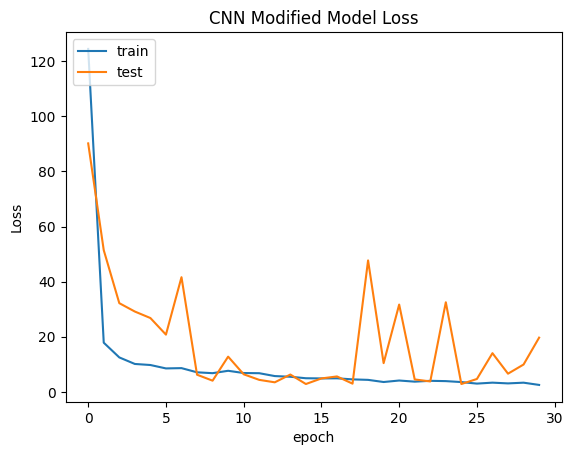

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
81
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 245.6282 - mae: 14.2720 - mse: 245.6282 - val_loss: 115.8941 - val_mae: 9.1001 - val_mse: 115.8941
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.3852 - mae: 3.1290 - mse: 18.3852 - val_loss: 45.4491 - val_mae: 4.4712 - val_mse: 45.4491
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.8707 - mae: 2.7396 - mse: 13.8707 - val_loss: 38.3159 - val_mae: 4.1095 - val_mse: 38.3159
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8743 - mae: 2.5448 - mse: 11.8743 - val_loss: 24.5386 - val_mae: 3.5010 - val_mse: 24.5386
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.7143 - mae: 2.4492 - mse: 10.7143 - val_loss: 25.7996 - val_mae: 3.3524 - val_mse: 25.7996
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.1545 - mae: 2.3544 - mse: 10.1545 - val_loss: 34.7665 - val_mae: 4.1945 - val_mse: 34.7665
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━

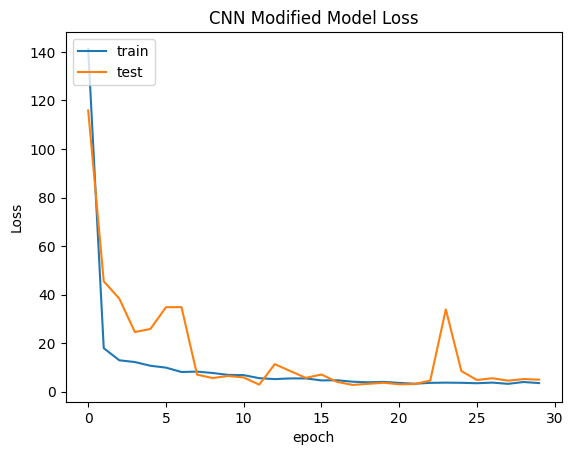

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
79
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 221.4696 - mae: 13.3994 - mse: 221.4696 - val_loss: 95.2841 - val_mae: 7.8328 - val_mse: 95.2841
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.1534 - mae: 3.3153 - mse: 21.1534 - val_loss: 33.7450 - val_mae: 3.6345 - val_mse: 33.7450
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.6891 - mae: 2.6714 - mse: 12.6891 - val_loss: 34.1446 - val_mae: 3.6926 - val_mse: 34.1446
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5549 - mae: 2.2747 - mse: 8.5549 - val_loss: 41.1950 - val_mae: 4.3129 - val_mse: 41.1950
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4183 - mae: 2.3413 - mse: 9.4183 - val_loss: 36.5290 - val_mae: 3.8106 - val_mse: 36.5290
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5038 - mae: 2.2420 - mse: 8.5038 - val_loss: 22.0693 - val_mae: 3.2788 - val_mse: 22.0693
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms

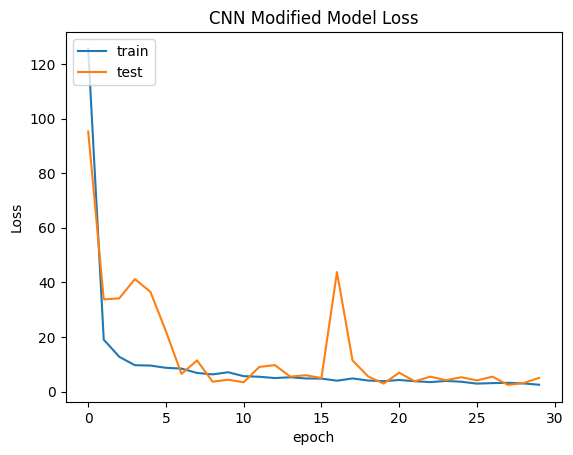

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
98
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 252.4668 - mae: 14.5000 - mse: 252.4668 - val_loss: 78.8915 - val_mae: 6.8320 - val_mse: 78.8915
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.8868 - mae: 3.1930 - mse: 18.8868 - val_loss: 44.9124 - val_mae: 4.4506 - val_mse: 44.9124
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6526 - mae: 2.6019 - mse: 11.6526 - val_loss: 31.8264 - val_mae: 3.4196 - val_mse: 31.8264
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8989 - mae: 2.2696 - mse: 8.8989 - val_loss: 38.9982 - val_mae: 4.1420 - val_mse: 38.9982
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9445 - mae: 2.1038 - mse: 7.9445 - val_loss: 30.0221 - val_mae: 3.8290 - val_mse: 30.0221
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5143 - mae: 2.1469 - mse: 8.5143 - val_loss: 18.6581 - val_mae: 2.8371 - val_mse: 18.6581
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

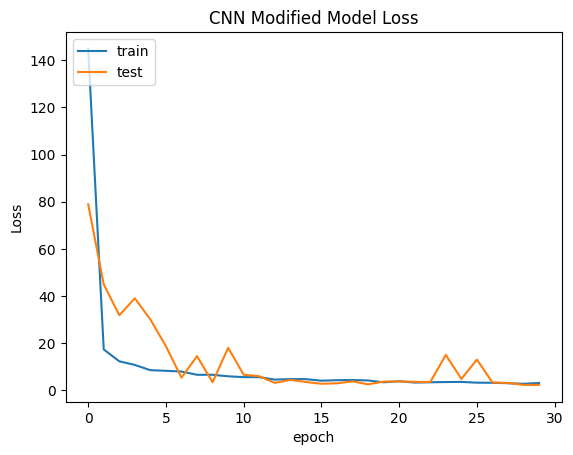

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
123
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 255.5842 - mae: 14.5919 - mse: 255.5842 - val_loss: 84.6272 - val_mae: 7.1651 - val_mse: 84.6272
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23.1493 - mae: 3.5979 - mse: 23.1493 - val_loss: 43.8906 - val_mae: 4.3142 - val_mse: 43.8906
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.5466 - mae: 2.9894 - mse: 16.5466 - val_loss: 57.8835 - val_mae: 5.0413 - val_mse: 57.8835
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0222 - mae: 2.6680 - mse: 13.0222 - val_loss: 44.9721 - val_mae: 4.2754 - val_mse: 44.9721
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.9751 - mae: 2.4478 - mse: 10.9751 - val_loss: 42.8867 - val_mae: 4.4548 - val_mse: 42.8867
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5981 - mae: 2.1901 - mse: 8.5981 - val_loss: 14.3513 - val_mae: 2.3545 - val_mse: 14.3513
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

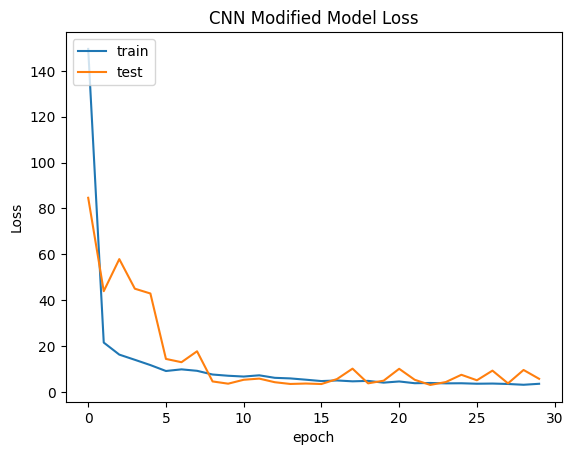

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
107
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 241.7969 - mae: 14.1581 - mse: 241.7969 - val_loss: 96.1475 - val_mae: 7.9396 - val_mse: 96.1475
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.2224 - mae: 3.3178 - mse: 20.2224 - val_loss: 45.6083 - val_mae: 4.5235 - val_mse: 45.6083
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.3685 - mae: 2.9808 - mse: 16.3685 - val_loss: 38.5396 - val_mae: 4.0138 - val_mse: 38.5396
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2758 - mae: 2.5531 - mse: 12.2758 - val_loss: 29.2972 - val_mae: 3.4654 - val_mse: 29.2972
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5493 - mae: 2.4581 - mse: 10.5493 - val_loss: 34.3934 - val_mae: 3.9597 - val_mse: 34.3934
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2501 - mae: 2.4135 - mse: 10.2501 - val_loss: 67.0563 - val_mae: 6.1812 - val_mse: 67.0563
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

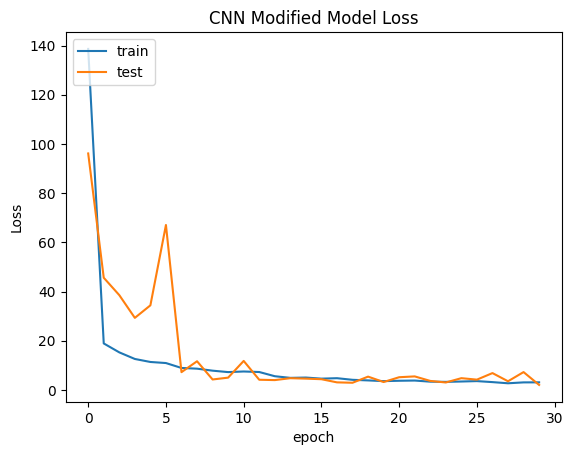

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
136
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 232.1795 - mae: 13.8450 - mse: 232.1795 - val_loss: 74.5668 - val_mae: 6.4932 - val_mse: 74.5668
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.8362 - mae: 3.3023 - mse: 19.8362 - val_loss: 45.2424 - val_mae: 4.3806 - val_mse: 45.2424
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1170 - mae: 2.9146 - mse: 16.1170 - val_loss: 46.1568 - val_mae: 4.4185 - val_mse: 46.1568
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.9115 - mae: 2.6226 - mse: 12.9115 - val_loss: 29.5854 - val_mae: 3.4564 - val_mse: 29.5854
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5018 - mae: 2.4519 - mse: 10.5018 - val_loss: 34.8264 - val_mae: 4.4822 - val_mse: 34.8264
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8029 - mae: 2.3589 - mse: 9.8029 - val_loss: 48.2191 - val_mae: 4.8392 - val_mse: 48.2191
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

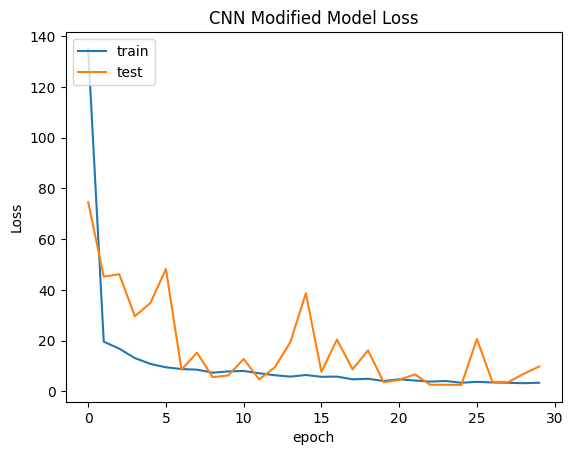

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
45
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 229.5292 - mae: 13.6143 - mse: 229.5292 - val_loss: 96.3099 - val_mae: 7.9322 - val_mse: 96.3099
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.7905 - mae: 3.2371 - mse: 19.7905 - val_loss: 57.1144 - val_mae: 5.0087 - val_mse: 57.1144
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.3085 - mae: 2.6109 - mse: 13.3085 - val_loss: 54.4824 - val_mae: 4.9468 - val_mse: 54.4824
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0298 - mae: 2.6531 - mse: 13.0298 - val_loss: 35.9396 - val_mae: 3.8912 - val_mse: 35.9396
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2770 - mae: 2.4197 - mse: 10.2770 - val_loss: 33.9131 - val_mae: 4.1052 - val_mse: 33.9131
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7112 - mae: 2.2560 - mse: 9.7112 - val_loss: 23.5502 - val_mae: 3.3984 - val_mse: 23.5502
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

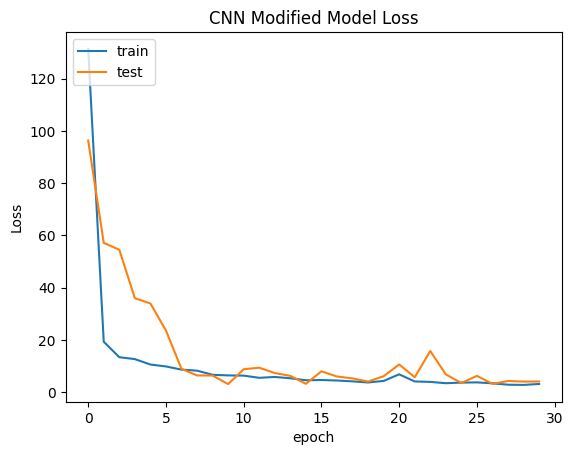

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
199
63
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 234.6693 - mae: 13.8050 - mse: 234.6693 - val_loss: 134.2129 - val_mae: 10.0642 - val_mse: 134.2129
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.9532 - mae: 3.3983 - mse: 21.9532 - val_loss: 50.1013 - val_mae: 4.7064 - val_mse: 50.1013
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.4785 - mae: 2.5777 - mse: 13.4785 - val_loss: 58.6535 - val_mae: 5.0308 - val_mse: 58.6535
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6041 - mae: 2.5660 - mse: 11.6041 - val_loss: 29.3295 - val_mae: 3.7035 - val_mse: 29.3295
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.0366 - mae: 2.5723 - mse: 12.0366 - val_loss: 45.3248 - val_mae: 5.0513 - val_mse: 45.3248
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2290 - mae: 2.3583 - mse: 10.2290 - val_loss: 41.4526 - val_mae: 4.5182 - val_mse: 41.4526
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━

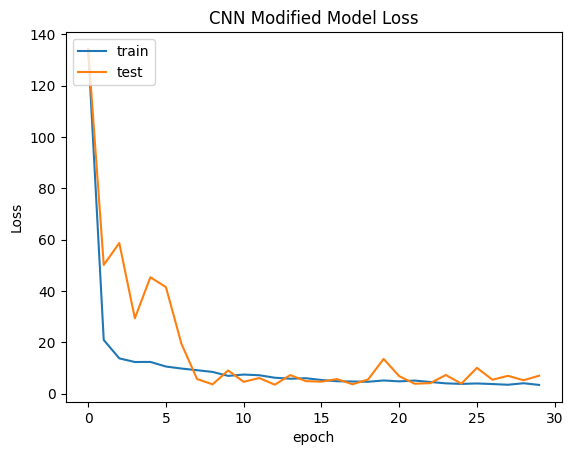

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
199
48
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 232.6493 - mae: 13.6982 - mse: 232.6493 - val_loss: 97.7686 - val_mae: 8.0524 - val_mse: 97.7686
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.6844 - mae: 3.5222 - mse: 22.6844 - val_loss: 41.7888 - val_mae: 4.1862 - val_mse: 41.7888
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.8913 - mae: 2.7167 - mse: 13.8913 - val_loss: 46.8690 - val_mae: 4.5141 - val_mse: 46.8690
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.1221 - mae: 2.5442 - mse: 11.1221 - val_loss: 49.9338 - val_mae: 4.7886 - val_mse: 49.9338
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2037 - mae: 2.3524 - mse: 10.2037 - val_loss: 61.9608 - val_mae: 5.5549 - val_mse: 61.9608
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6995 - mae: 2.2089 - mse: 8.6995 - val_loss: 20.9046 - val_mae: 3.3984 - val_mse: 20.9046
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

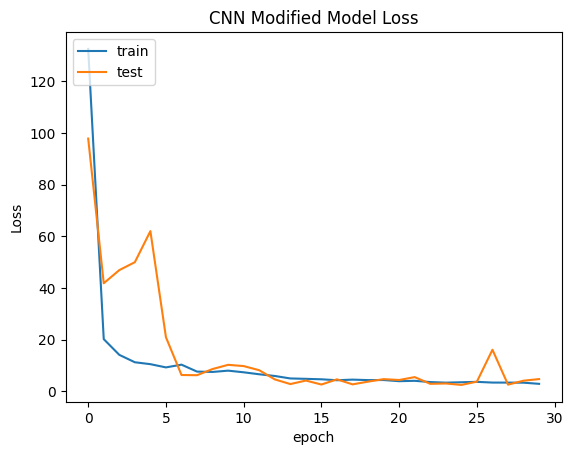

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
80
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 229.3167 - mae: 13.6558 - mse: 229.3167 - val_loss: 99.1969 - val_mae: 8.1279 - val_mse: 99.1969
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 25.4785 - mae: 3.6768 - mse: 25.4785 - val_loss: 60.2352 - val_mae: 5.3579 - val_mse: 60.2352
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.4952 - mae: 2.9624 - mse: 16.4952 - val_loss: 51.6471 - val_mae: 4.9825 - val_mse: 51.6471
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.4415 - mae: 2.8084 - mse: 14.4415 - val_loss: 29.1230 - val_mae: 3.3992 - val_mse: 29.1230
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.6057 - mae: 2.6849 - mse: 12.6057 - val_loss: 36.2607 - val_mae: 4.1185 - val_mse: 36.2607
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.0717 - mae: 2.4439 - mse: 11.0717 - val_loss: 34.9009 - val_mae: 4.7594 - val_mse: 34.9009
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

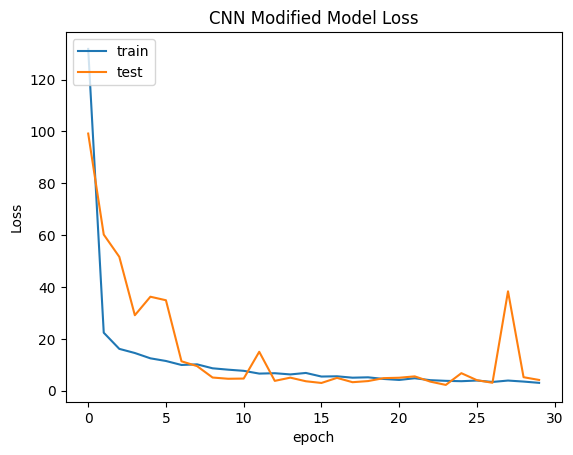

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
111
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 259.7010 - mae: 14.6998 - mse: 259.7010 - val_loss: 62.0724 - val_mae: 5.3346 - val_mse: 62.0724
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.7859 - mae: 3.5256 - mse: 21.7859 - val_loss: 65.1179 - val_mae: 5.6368 - val_mse: 65.1179
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1494 - mae: 2.8953 - mse: 16.1494 - val_loss: 56.0871 - val_mae: 5.0355 - val_mse: 56.0871
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3890 - mae: 2.3519 - mse: 10.3890 - val_loss: 56.3949 - val_mae: 5.0457 - val_mse: 56.3949
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7071 - mae: 2.2882 - mse: 9.7071 - val_loss: 53.4067 - val_mae: 4.7204 - val_mse: 53.4067
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0822 - mae: 2.3552 - mse: 10.0822 - val_loss: 31.0294 - val_mae: 3.2841 - val_mse: 31.0294
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

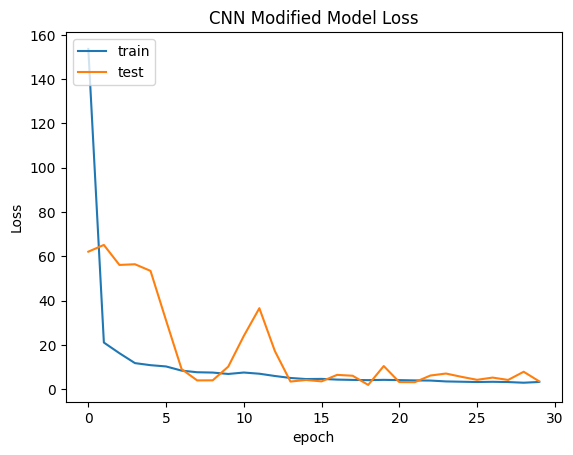

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
125
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 271.9612 - mae: 15.1364 - mse: 271.9612 - val_loss: 136.1058 - val_mae: 10.1262 - val_mse: 136.1058
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.8656 - mae: 3.5179 - mse: 22.8656 - val_loss: 75.7194 - val_mae: 6.5227 - val_mse: 75.7194
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.9864 - mae: 2.9080 - mse: 15.9864 - val_loss: 60.1115 - val_mae: 5.3337 - val_mse: 60.1115
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9647 - mae: 2.5787 - mse: 11.9647 - val_loss: 49.6738 - val_mae: 4.6013 - val_mse: 49.6738
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3735 - mae: 2.3764 - mse: 10.3735 - val_loss: 44.4260 - val_mae: 4.2713 - val_mse: 44.4260
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8244 - mae: 2.2120 - mse: 8.8244 - val_loss: 23.9571 - val_mae: 3.0830 - val_mse: 23.9571
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━

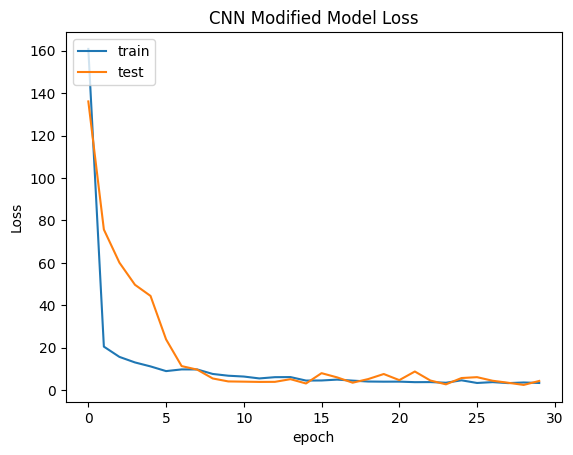

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
54
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 229.7374 - mae: 13.7776 - mse: 229.7374 - val_loss: 70.0430 - val_mae: 6.0451 - val_mse: 70.0430
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.3066 - mae: 3.1120 - mse: 18.3066 - val_loss: 44.6191 - val_mae: 4.3471 - val_mse: 44.6191
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.8396 - mae: 2.7694 - mse: 14.8396 - val_loss: 39.2553 - val_mae: 3.8167 - val_mse: 39.2553
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0609 - mae: 2.6791 - mse: 13.0609 - val_loss: 32.6073 - val_mae: 3.3927 - val_mse: 32.6073
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3136 - mae: 2.2737 - mse: 9.3136 - val_loss: 29.8648 - val_mae: 3.3699 - val_mse: 29.8648
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5022 - mae: 2.2937 - mse: 9.5022 - val_loss: 16.9088 - val_mae: 3.3691 - val_mse: 16.9088
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8

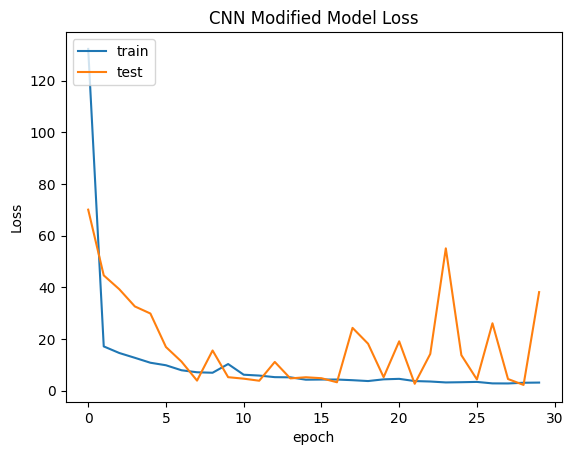

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
76
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 246.1836 - mae: 14.2972 - mse: 246.1836 - val_loss: 85.5225 - val_mae: 7.2258 - val_mse: 85.5225
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.9157 - mae: 3.0664 - mse: 16.9157 - val_loss: 50.1743 - val_mae: 4.6990 - val_mse: 50.1743
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8874 - mae: 2.5734 - mse: 11.8874 - val_loss: 31.4369 - val_mae: 3.8533 - val_mse: 31.4369
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2219 - mae: 2.4087 - mse: 10.2219 - val_loss: 31.0268 - val_mae: 3.9051 - val_mse: 31.0268
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9106 - mae: 2.1513 - mse: 7.9106 - val_loss: 23.3212 - val_mae: 3.3407 - val_mse: 23.3212
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4115 - mae: 2.3679 - mse: 9.4115 - val_loss: 28.6089 - val_mae: 3.9053 - val_mse: 28.6089
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8

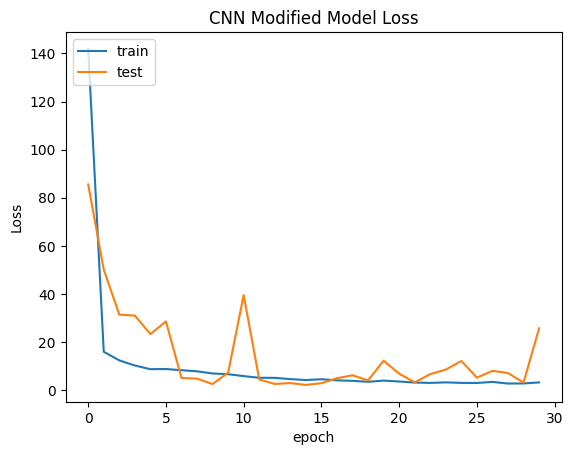

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
32
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 239.6820 - mae: 14.1640 - mse: 239.6820 - val_loss: 116.5933 - val_mae: 9.1673 - val_mse: 116.5933
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.9570 - mae: 3.2286 - mse: 18.9570 - val_loss: 39.6629 - val_mae: 4.0480 - val_mse: 39.6629
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.7237 - mae: 2.5125 - mse: 11.7237 - val_loss: 30.8324 - val_mae: 3.7699 - val_mse: 30.8324
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9625 - mae: 2.2776 - mse: 8.9625 - val_loss: 33.4473 - val_mae: 3.6782 - val_mse: 33.4473
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1207 - mae: 2.1992 - mse: 8.1207 - val_loss: 26.7005 - val_mae: 3.3815 - val_mse: 26.7005
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7852 - mae: 2.1689 - mse: 7.7852 - val_loss: 15.2137 - val_mae: 2.6578 - val_mse: 15.2137
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8

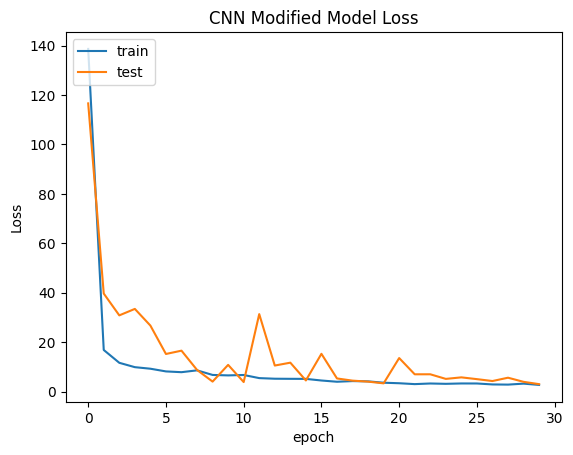

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
199
113
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 235.7349 - mae: 13.9923 - mse: 235.7349 - val_loss: 180.3820 - val_mae: 12.1527 - val_mse: 180.3820
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.2383 - mae: 3.0026 - mse: 17.2383 - val_loss: 71.3432 - val_mae: 6.2880 - val_mse: 71.3432
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.0063 - mae: 2.6138 - mse: 12.0063 - val_loss: 50.5358 - val_mae: 4.7991 - val_mse: 50.5358
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.3029 - mae: 2.5931 - mse: 12.3029 - val_loss: 50.1427 - val_mae: 4.9335 - val_mse: 50.1427
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.6279 - mae: 2.1246 - mse: 7.6279 - val_loss: 34.5170 - val_mae: 3.9677 - val_mse: 34.5170
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3675 - mae: 2.1142 - mse: 7.3675 - val_loss: 13.1184 - val_mae: 2.7855 - val_mse: 13.1184
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 

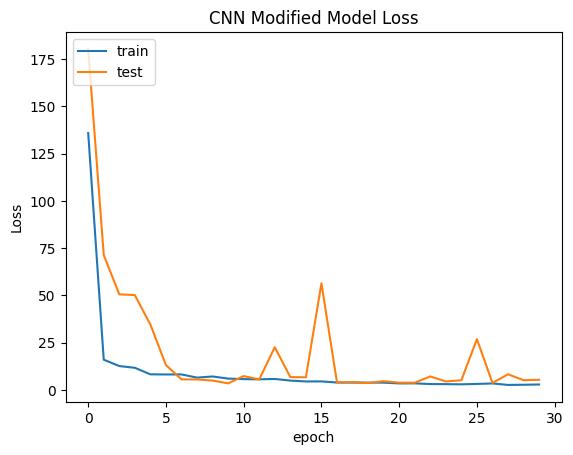

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
100
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 217.0728 - mae: 13.2565 - mse: 217.0728 - val_loss: 90.2082 - val_mae: 7.5803 - val_mse: 90.2082
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.2464 - mae: 3.0981 - mse: 18.2464 - val_loss: 47.3988 - val_mae: 4.6144 - val_mse: 47.3988
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.1417 - mae: 2.7439 - mse: 13.1417 - val_loss: 34.4129 - val_mae: 3.6660 - val_mse: 34.4129
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.4788 - mae: 2.6126 - mse: 12.4788 - val_loss: 36.3226 - val_mae: 5.2455 - val_mse: 36.3226
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6478 - mae: 2.2676 - mse: 8.6478 - val_loss: 89.2281 - val_mae: 7.3861 - val_mse: 89.2281
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8557 - mae: 2.2846 - mse: 8.8557 - val_loss: 53.4102 - val_mae: 5.1396 - val_mse: 53.4102
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 

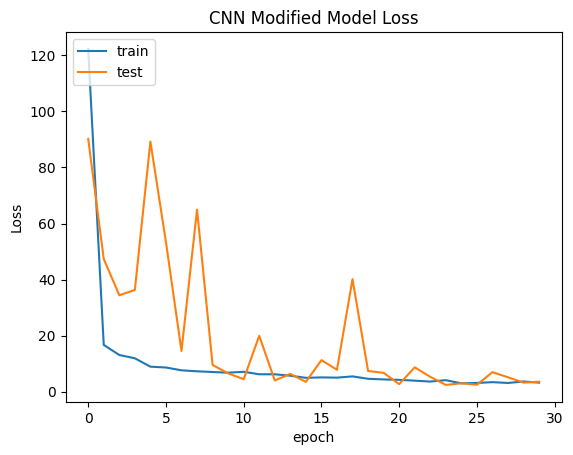

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
199
116
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 247.8262 - mae: 14.4397 - mse: 247.8262 - val_loss: 116.8819 - val_mae: 9.1867 - val_mse: 116.8819
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.9338 - mae: 3.2129 - mse: 18.9338 - val_loss: 50.7947 - val_mae: 4.7971 - val_mse: 50.7947
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.6287 - mae: 2.7829 - mse: 13.6287 - val_loss: 30.1242 - val_mae: 3.8097 - val_mse: 30.1242
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0862 - mae: 2.3527 - mse: 10.0862 - val_loss: 29.0557 - val_mae: 3.3017 - val_mse: 29.0557
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3189 - mae: 2.3221 - mse: 9.3189 - val_loss: 28.1965 - val_mae: 4.1088 - val_mse: 28.1965
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9661 - mae: 2.0124 - mse: 6.9661 - val_loss: 40.1803 - val_mae: 4.7045 - val_mse: 40.1803
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1

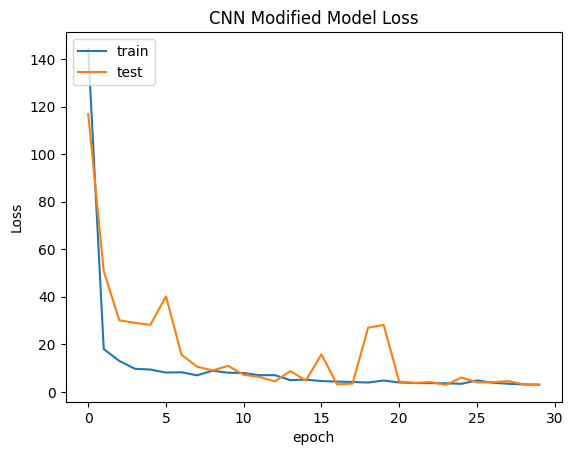

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
132
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 239.3589 - mae: 14.1051 - mse: 239.3589 - val_loss: 132.9687 - val_mae: 10.0270 - val_mse: 132.9687
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.7558 - mae: 3.3708 - mse: 20.7558 - val_loss: 75.4526 - val_mae: 6.5065 - val_mse: 75.4526
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.3385 - mae: 2.7470 - mse: 14.3385 - val_loss: 44.9547 - val_mae: 4.4699 - val_mse: 44.9547
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2121 - mae: 2.5681 - mse: 12.2121 - val_loss: 35.4970 - val_mae: 3.7982 - val_mse: 35.4970
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2531 - mae: 2.3606 - mse: 10.2531 - val_loss: 26.8513 - val_mae: 3.1386 - val_mse: 26.8513
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7024 - mae: 2.1830 - mse: 8.7024 - val_loss: 15.4049 - val_mae: 2.4748 - val_mse: 15.4049
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━

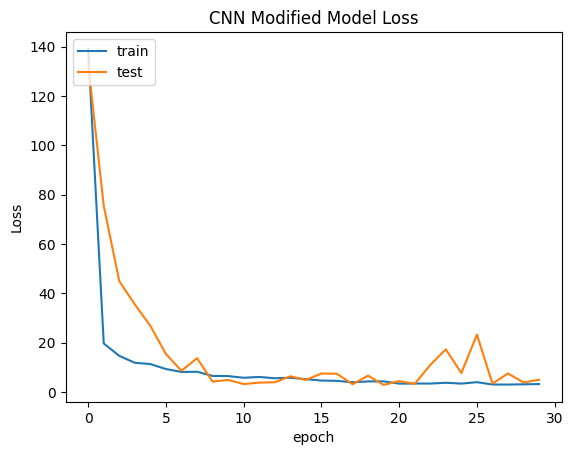

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
97
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 235.9017 - mae: 13.9105 - mse: 235.9017 - val_loss: 90.7445 - val_mae: 7.5540 - val_mse: 90.7445
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24.3236 - mae: 3.5316 - mse: 24.3236 - val_loss: 33.5449 - val_mae: 3.7809 - val_mse: 33.5449
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.4021 - mae: 2.7354 - mse: 14.4021 - val_loss: 41.5477 - val_mae: 4.1104 - val_mse: 41.5477
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.3900 - mae: 2.5955 - mse: 12.3900 - val_loss: 44.5782 - val_mae: 4.2832 - val_mse: 44.5782
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3959 - mae: 2.3959 - mse: 10.3959 - val_loss: 32.6128 - val_mae: 3.5025 - val_mse: 32.6128
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5508 - mae: 2.2628 - mse: 9.5508 - val_loss: 33.6068 - val_mae: 3.6253 - val_mse: 33.6068
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

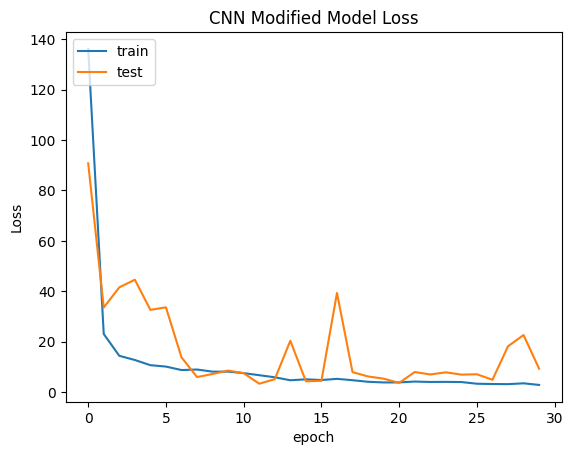

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
199
89
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 221.4902 - mae: 13.4528 - mse: 221.4902 - val_loss: 92.8210 - val_mae: 7.6911 - val_mse: 92.8210
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.2040 - mae: 3.2537 - mse: 20.2040 - val_loss: 44.3114 - val_mae: 4.3400 - val_mse: 44.3114
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1214 - mae: 2.9498 - mse: 16.1214 - val_loss: 42.3227 - val_mae: 4.1812 - val_mse: 42.3227
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.2910 - mae: 2.5123 - mse: 11.2910 - val_loss: 36.3895 - val_mae: 3.6433 - val_mse: 36.3895
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2428 - mae: 2.4035 - mse: 10.2428 - val_loss: 36.2383 - val_mae: 3.8350 - val_mse: 36.2383
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2604 - mae: 2.3617 - mse: 9.2604 - val_loss: 15.1408 - val_mae: 2.6714 - val_mse: 15.1408
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

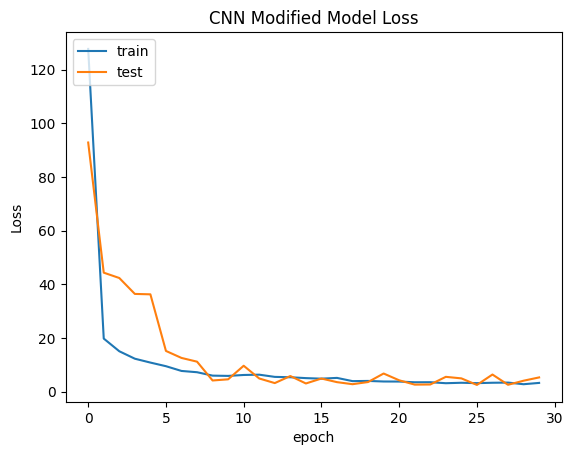

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
117
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 220.5055 - mae: 13.3417 - mse: 220.5055 - val_loss: 97.4749 - val_mae: 8.0566 - val_mse: 97.4749
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.0552 - mae: 3.2850 - mse: 21.0552 - val_loss: 92.7263 - val_mae: 7.7380 - val_mse: 92.7263
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.1255 - mae: 2.8848 - mse: 15.1255 - val_loss: 87.4981 - val_mae: 7.4247 - val_mse: 87.4981
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.8439 - mae: 2.7015 - mse: 13.8439 - val_loss: 101.1739 - val_mae: 8.2755 - val_mse: 101.1739
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.3934 - mae: 2.5866 - mse: 11.3934 - val_loss: 68.7165 - val_mae: 6.2161 - val_mse: 68.7165
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9926 - mae: 2.4098 - mse: 9.9926 - val_loss: 44.5443 - val_mae: 4.7967 - val_mse: 44.5443
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

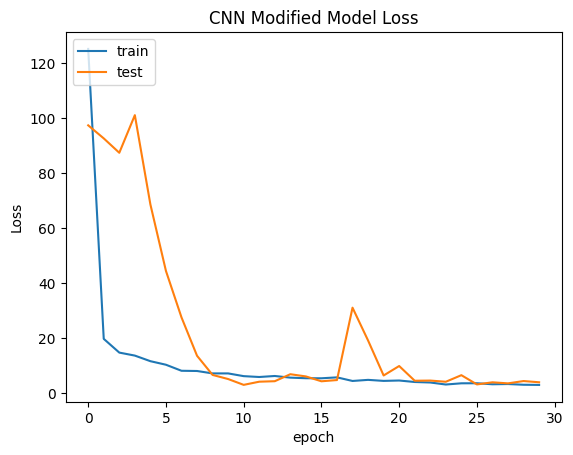

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
122
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 232.3924 - mae: 13.8142 - mse: 232.3924 - val_loss: 112.3808 - val_mae: 8.9061 - val_mse: 112.3808
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.3806 - mae: 3.3328 - mse: 20.3806 - val_loss: 63.0747 - val_mae: 5.5937 - val_mse: 63.0747
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.1688 - mae: 2.8305 - mse: 15.1688 - val_loss: 55.8200 - val_mae: 5.0367 - val_mse: 55.8200
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.5813 - mae: 2.7209 - mse: 13.5813 - val_loss: 48.6091 - val_mae: 4.6066 - val_mse: 48.6091
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5845 - mae: 2.4887 - mse: 10.5845 - val_loss: 30.2020 - val_mae: 3.8060 - val_mse: 30.2020
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1118 - mae: 2.2847 - mse: 9.1118 - val_loss: 55.1931 - val_mae: 5.6086 - val_mse: 55.1931
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━

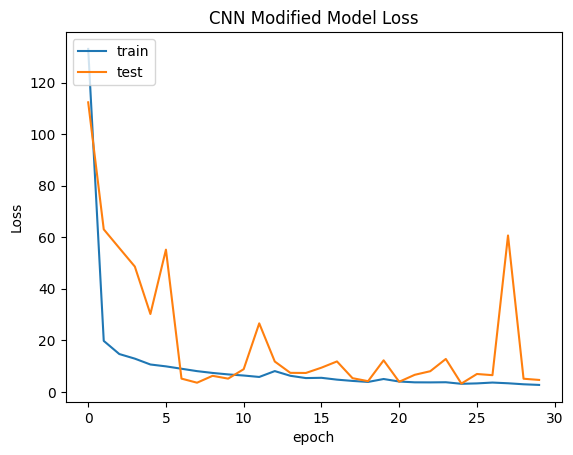

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
199
95
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 226.6576 - mae: 13.5147 - mse: 226.6576 - val_loss: 98.1734 - val_mae: 8.0340 - val_mse: 98.1734
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.7378 - mae: 3.4737 - mse: 22.7378 - val_loss: 42.7451 - val_mae: 4.2574 - val_mse: 42.7451
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.1346 - mae: 2.8156 - mse: 15.1346 - val_loss: 57.8659 - val_mae: 5.1667 - val_mse: 57.8659
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.9692 - mae: 2.8885 - mse: 14.9692 - val_loss: 56.1712 - val_mae: 4.9906 - val_mse: 56.1712
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3401 - mae: 2.4368 - mse: 10.3401 - val_loss: 35.9744 - val_mae: 3.9578 - val_mse: 35.9744
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9426 - mae: 2.2467 - mse: 8.9426 - val_loss: 34.9354 - val_mae: 4.4674 - val_mse: 34.9354
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s

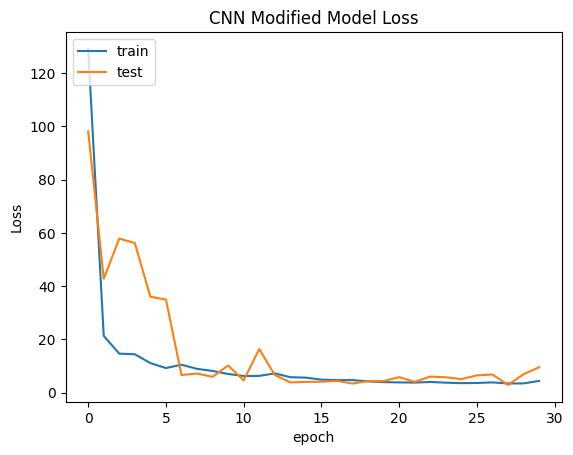

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
199
72


In [24]:
#  Create the model
l_model = []
l_hits = []
for i in range(50):
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3, 3), strides = (1,1), padding = 'same',activation='relu', input_shape=(250, 250,1)))
  model.add(layers.BatchNormalization())
  model.add(layers.PReLU())
  model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
  model.add(layers.Conv2D(32, (5, 5), strides = (1,1), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.PReLU())
  model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
  model.add(layers.Conv2D(64, (3, 3), strides = (1,1), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.PReLU())
  model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
  model.add(layers.Conv2D(128, (3, 3), strides = (1,1), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.PReLU())
  model.add(layers.MaxPooling2D((3, 3), strides = (2,2), padding = 'valid'))
  model.add(layers.Conv2D(512, (3, 3), strides = (1,1), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.PReLU())
  model.add(layers.AveragePooling2D((3, 3), strides = (2,2), padding = 'valid'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  # Compile the model
  model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae', 'mse'])

  # Train the model
  history = model.fit(train_images, train_labels, epochs=30,
                      validation_data=(test_images, test_labels),
                      batch_size=10)

  # Evaluate the model
  test_loss, test_mae, test_mse = model.evaluate(test_images, test_labels)
  print("Test MAE:", test_mae)

# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('CNN Modified Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  predictions_test = model.predict(test_images)
  print(len(predictions_test))
  count = 0
  for i in range(len(predictions_test)):

    error = float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i])
    if error <= 5.00:
      count += 1
      # print(predictions_test[i])
      # print(float(test_labels[i]))
      # print('% error: ', float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i]))
      # print('#########\n')
  print(count)
  hits = round(count*100/len(predictions_test), 2)
  # print("hits: %", )
  l_hits.append(hits)
  # print("Test MSE:", test_mse)
  l_model.append(model)


In [51]:
# Statistics
mean = statistics.mean(l_hits)

stdev = statistics.stdev(l_hits)

print(f"Mean: {mean}")
print(f"Standard Deviation: {stdev}")

Mean: 46.1002
Standard Deviation: 13.445101450729487


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 241.4126 - mae: 14.1538 - mse: 241.4126 - val_loss: 104.3466 - val_mae: 8.4537 - val_mse: 104.3466
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.3360 - mae: 3.3288 - mse: 20.3360 - val_loss: 66.8205 - val_mae: 5.9164 - val_mse: 66.8205
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.8522 - mae: 2.6925 - mse: 12.8522 - val_loss: 64.6035 - val_mae: 5.8973 - val_mse: 64.6035
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.0313 - mae: 2.6361 - mse: 12.0313 - val_loss: 62.0606 - val_mae: 5.7702 - val_mse: 62.0606
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.0930 - mae: 2.4259 - mse: 10.0930 - val_loss: 30.0833 - val_mae: 3.6549 - val_mse: 30.0833
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8888 - mae: 2.2522 - mse: 8.8888 - val_loss: 10.3790 - val_mae: 2.3813 - val_mse: 10.3790
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0748 - mae: 2.2996 - ms

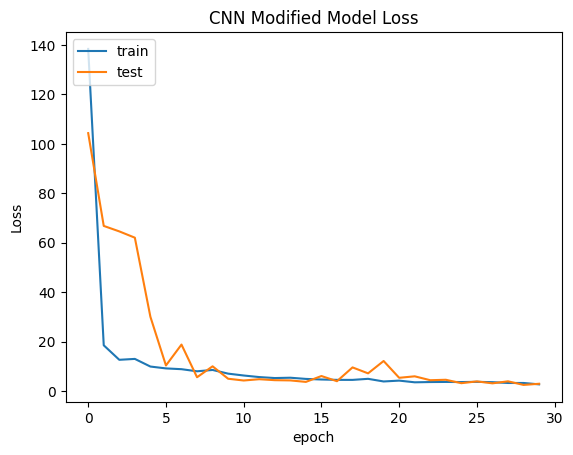

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
199
124
hits: % 62.31


In [40]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), strides = (1,1), padding = 'same',activation='relu', input_shape=(250, 250,1)))
model.add(layers.BatchNormalization())
model.add(layers.PReLU())
model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
model.add(layers.Conv2D(32, (5, 5), strides = (1,1), padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.PReLU())
model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
model.add(layers.Conv2D(64, (3, 3), strides = (1,1), padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.PReLU())
model.add(layers.MaxPooling2D((5, 5), strides = (3,3), padding = 'valid'))
model.add(layers.Conv2D(128, (3, 3), strides = (1,1), padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.PReLU())
model.add(layers.MaxPooling2D((3, 3), strides = (2,2), padding = 'valid'))
model.add(layers.Conv2D(512, (3, 3), strides = (1,1), padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.PReLU())
model.add(layers.AveragePooling2D((3, 3), strides = (2,2), padding = 'valid'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1))

  # Compile the model
model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae', 'mse'])

  # Train the model
history = model.fit(train_images, train_labels, epochs=30,
                      validation_data=(test_images, test_labels),
                      batch_size=10)

  # Evaluate the model
test_loss, test_mae, test_mse = model.evaluate(test_images, test_labels)
print("Test MAE:", test_mae)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Modified Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
predictions_test = model.predict(test_images)
print(len(predictions_test))
count = 0
for i in range(len(predictions_test)):

    error = float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i])
    if error <= 5.00:
      count += 1
      # print(predictions_test[i])
      # print(float(test_labels[i]))
      # print('% error: ', float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i]))
      # print('#########\n')
print(count)
hits = round(count*100/len(predictions_test), 2)
print("hits: %", hits)

  # print("Test MSE:", test_mse)

In [50]:
model.save('best_model.h5')

# Prediction Analysis

In [44]:
predictions_test = model.predict(test_images)
print(len(predictions_test))
count = 0
for i in range(len(predictions_test)):

  error = float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i])
  if error <= 5.00:
    count += 1

print(count)
print("hits: %", round(count*100/len(predictions_test), 2))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
199
124
hits: % 62.31


In [48]:
predictions_test = model.predict(val_images)
print(len(predictions_test))
count = 0
for i in range(len(predictions_test)):

  error = float(abs(predictions_test[i]-val_labels[i])*100/val_labels[i])
  if error <= 5.00:
    count += 1

print(count)
print("hits: %", round(count*100/len(predictions_test), 2))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
200
112
hits: % 56.0


<ipython-input-48-80418fc08817>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions_test[i]-val_labels[i])*100/val_labels[i])
